In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import datetime, timedelta
import tensorflow as tf
import random

seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)

In [2]:
df = pd.read_csv(r"C:\Users\Bogdan\OneDrive - University of Warwick\Desktop\Projects\(GOV BONDS) Yield Curve Arbitrage\Data\Expected values of predictor variables (6 mo horizon - 31-12-2024)\Work\5-Year, 5-Year Forward Inflation Expectation Rate\Data.csv")
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE')
name = "T5YIFRM"

data = df[name] # only care about this column
dataset = np.array(data).reshape(-1,1)#convert the column to an array and this will be 1-D array # then you need to rehape to a 2-D array cause minMaxScaler takes 2-D arrays and for that use reshape(-1,1) cause you know you want 1 column and the rows are automaticall calculated to satisfy the 1 columns and beleiv it is just the shape[0]
scaler = MinMaxScaler(feature_range=(0, 1)) #this is called normalizing (an action that is performed on an array). Here you only specify the range.
scaled_data = scaler.fit_transform(dataset) #maps values in the array to a values in the interval (0,1) while keeping the same distribution of dataset. Reason: MLs work best if all data is scaled similarly.
training_data_len = int(len(dataset) * 0.8) #here I look at the length of my original data and take 80% of it and I need an intiger because ill use the value as input an need intiger
train_data = scaled_data[0:training_data_len, :] #this is the subset of my scaled data that I will use for taining the ML scaled_data[rows,columns]
test_data = scaled_data[training_data_len:, :] #this is the subset of my scaled data that I will use for testing the ML (in short this data is unseen to the ML and fed to the ML after it was trained to spit the predictions it was trained to do)
#here you can also have an overlap between the 2 datasets for xyz reasons but I kept it simple 80% seen and 20% unseen

In [3]:
x_train = []
y_train = []
window_size = 30 #this means I believe 12 sequential values are good enough for the ML to take in so as to predict the 13th
for i in range(window_size, len(train_data)):
    x_train.append(train_data[i-window_size:i, 0])
    y_train.append(train_data[i, 0])
#print(x_train[:2])
#print(y_train)
#these are lists of arrays

In [4]:
x_train = np.array(x_train) #this is the array with the sequences of values that are used as input for training
y_train = np.array(y_train) #this is the array with the predictions that are used for training
#in a nutshell both arrays are used for training. x is the input and y is the output and the ML learns to mimic the process meaning given 12 values spit the 13th. And because here you don't actually predict anything since all values are known you use this to train the ML meaning the ML takes the data you just inputed as input and output for granted
#the above are singular arrays ok
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) #this is an array of arrays #kinda intuitive that you need that because y_train is safe to be a singlular arry cause you match the 12 values to 1 prediction so that 1 prediction can be the first element of an array but the 12 values are the first element of an array too so that is why you need arrays of arrays because for x the "first value" is the 12 values which you gotta stuff into an array cause you need to understand that there are 12 values stuck in there
#print(x_train) this is a 3-D array

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import KFold
import numpy as np

# Function to create the LSTM model
def create_model(batch_size):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(window_size, 1)))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Parameters to iterate over
batch_sizes = [8, 16, 32]
epochs = [10, 20, 30]
kf = KFold(n_splits=3)

best_score = np.inf
best_params = {}

for batch in batch_sizes:
    for epoch in epochs:
        scores = []
        for train_index, test_index in kf.split(x_train):
            model = create_model(batch)
            x_train_fold, x_test_fold = x_train[train_index], x_train[test_index]
            y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
            model.fit(x_train_fold, y_train_fold, batch_size=batch, epochs=epoch, verbose=0)
            scores.append(model.evaluate(x_test_fold, y_test_fold, verbose=0))
        average_score = np.mean(scores)
        if average_score < best_score:
            best_score = average_score
            best_params = {'batch_size': batch, 'epochs': epoch}

print(f"Best Score: {best_score} using {best_params}")

c:\Users\Bogdan\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best Score: 0.015520235213140646 using {'batch_size': 8, 'epochs': 30}


In [6]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(window_size, 1))) #50 is the number of units/neurons, return_sequences = True means this layer will return a sequence of vectors each containing the states of the neurons at one timestep of the input sequence that is of length window_size to the next layer  input_shape declares the structure of the input expected. here you have arrays of 12x1
#in short this layer returns a sequence of 12/window_size vectors with each vector containing 50 elements/states representing states of the neurons
#what happens is you feed the first value of the input_sequence(to be determined) to all neurons simultaneously then you save the state of all neurons in a vector (that is the very first vector containing 50 elements/states at timestep 1 which is the first value fed). Aterwards you feed the second value to all neurons, the states might change and save the states to the second vector and so on
model.add(LSTM(50, return_sequences=False))#return_sequences=Flase means the layer will return the vector containing the neuron states at the last timestep
model.add(Dense(25))#25 neurons all connected to the previous layer's neurons,  each neuron in dense does a weighted sum of the inputs it receives, output 25 values computed as a weighted sum of inputs.
model.add(Dense(1))#1 neuron that will output a single value computed as a weighted sum of its inputs.

model.compile(optimizer='adam', loss='mean_squared_error') #this configures the model to aim to minimize the loss function = MSE by adapting the weights assigned to parameters by the Adam algorithm
model.fit(x_train, y_train, batch_size=8, epochs=30) #batch_size = 1 means that I want to take 1 input at a time so one of those 12x1 arrays at a time + model will update its weights after each sample epochs=1 means I want to go through all the x_train dataset once
#also y_train is the results dataset that you calculate the predictions MSE against in the training stage. So the model will take the first array within x_train array, will start off by having random weights (input + recurrent) which will be adjusted to minimize the MSE. This process occurs for the number of batches and what you want to happen is to get to a point where the weights converge to a value
#this ML model skips the validation stage (will be covered as I learn) this means we use the default settings of adam

Epoch 1/30


15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - loss: 0.1556
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0349
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0241
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0225
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0208
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0192
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0181
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0170
Epoch 9/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0162
Epoch 10/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0156
Epoch 11/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0150
Epoch 12/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0145
Epoch 13/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0140
Epoch 14/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0136
Epoch 15/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0132
Epoch 16/30
15

In [7]:
x_test = [] #list of 2d arrays
y_test = [] #same
window_size = 30 #this means I believe 60 sequential values are good enough for the ML to take in so as to predict the 13
for i in range(window_size, len(test_data)):
    x_test.append(test_data[i-window_size:i, 0])
    y_test.append(test_data[i, 0])

x_test = np.array(x_test) #2d array
y_test = np.array(y_test) #2d array

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1)) #convert to a 3-D array like before

predictions = model.predict(x_test) #applies the trained model to the input data x_test and outputs predictions based on the learned patterns and relationships in the training data.
predictions = scaler.inverse_transform(predictions) #transform predicted values back to their original scale or units before they were normalized

train = data[:training_data_len]#wanna plot all the observations used for training
the_test_window = data[training_data_len:training_data_len + window_size]
test = data[training_data_len + window_size:]#wanna plot all the observations that follow after the ones used for training
test = pd.DataFrame(test)
test['Predictions'] = predictions #create a column in valid where I store the predictions
test


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


,T5YIFRM,Predictions
DATE,,
2024-02-01,2.25,2.296103
2024-03-01,2.24,2.257312
2024-04-01,2.34,2.227810
2024-05-01,2.34,2.245512
2024-06-01,2.30,2.269598
2024-07-01,2.36,2.276003


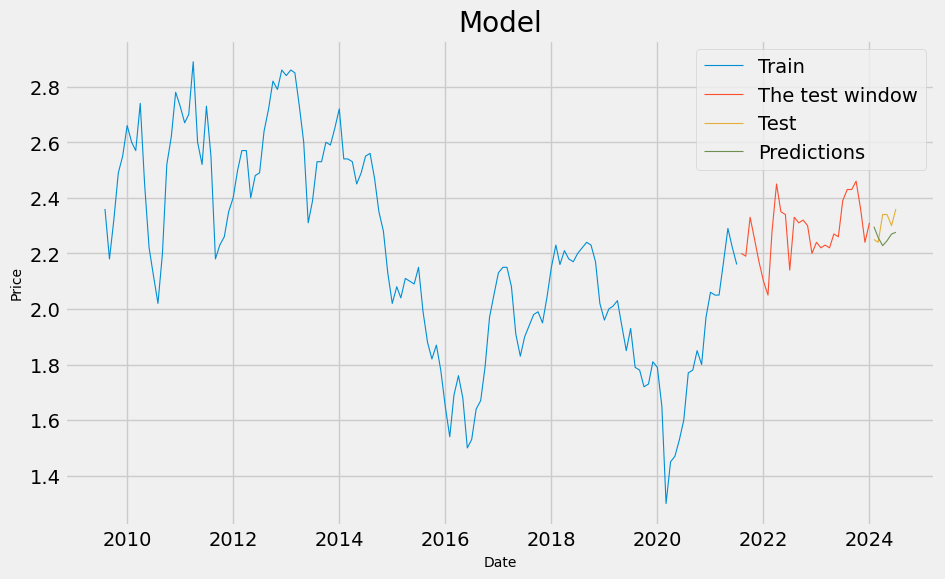

In [8]:
plt.figure(figsize=(10, 6))
plt.title("Model")
plt.xlabel("Date", fontsize=10)
plt.ylabel("Price", fontsize=10)
plt.plot(train.index, train, label="Train", linewidth=0.8)
plt.plot(the_test_window.index, the_test_window, label = 'The test window', linewidth=0.8)
plt.plot(test.index, test[name], label="Test", linewidth=0.8)
plt.plot(test.index, test["Predictions"], label="Predictions", linewidth=0.8)
plt.legend()
plt.show()

In [9]:
residuals = test[name] - test['Predictions']

print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 0.07293790121717468
